In [50]:
"""
HLSS30 and HLSL30 processessing for pre-fire conditions
Author: maxwell.cook@colorado.edu
"""

import sys, os
import earthaccess as ea
import geopandas as gpd
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import matplotlib.pyplot as plt

from osgeo import gdal
from datetime import datetime
from datetime import timedelta
from pprint import pprint
from skimage import io

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Directories
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
datamod = os.path.join(projdir,'data/spatial/mod/HLSS/')
if not os.path.exists(datamod):
    os.makedirs(datamod)

print("Ready !")

Ready !


In [2]:
# load the fire bounds
fires = os.path.join(projdir, 'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg')
fires = gpd.read_file(fires)
fires.columns

Index(['NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_cover',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'WF_CESSATION_DATE', 'WF_CESSATION_DOY',
       'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL',
       'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')

In [ ]:
# set up an earthaccess search for one fire

In [3]:
fires['DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'])

In [23]:
# get the fire information

fire = fires[fires['NIFC_NAME'] == '416']

end_date = fire['DISCOVERY_DATE'].iloc[0] - timedelta(days=1)
start_date = end_date - timedelta(days=14)
date_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
print(f"Date range: {date_range}")

coords, extent = get_coords(fire, buffer=1000)
print(f"Bounding extent of fire: \n{extent}\n")

# initiate the search request
results = ea.search_data(
    short_name=['HLSL30','HLSS30'],  # HLSS30 for Sentinel-2, HLSL30 for Landsat-8
    polygon=coords,
    temporal=date_range, 
    cloud_hosted=True,
    count=-1
)

Date range: ('2018-05-17', '2018-05-31')
Bounding extent of fire: 
[-108.01368250774742, -107.79103762578121, 37.37482877467364, 37.61153656011201]

Granules found: 15


In [24]:
results[1]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -108.367413, 'Latitude': 36.91011916}, {'Longitude': -107.33127283, 'Latitude': 36.93499362}, {'Longitude': -107.15229798, 'Latitude': 37.51318206}, {'Longitude': -107.16432984, 'Latitude': 37.92768043}, {'Longitude': -108.41197248, 'Latitude': 37.89809979}, {'Longitude': -108.367413, 'Latitude': 36.91011916}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-05-17T17:49:26.453Z', 'EndingDateTime': '2018-05-17T17:49:26.453Z'}}
Size(MB): 183.25008583068848
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B04.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B07.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SBB.2018137T174926.v2.0/HLS.L30.T13SBB.2018137T174926.v2.0.B11.tif']

In [25]:
hls_results_urls = [granule.data_links() for granule in results]
print(f"There are {len(hls_results_urls)} granules and each granule contains {len(hls_results_urls[0])} assets.")

There are 15 granules and each granule contains 15 assets.


In [28]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')

In [42]:
print(hls_results_urls[0]) # one granule, all 15 bands

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020

In [48]:
evi_band_links = []

h = hls_results_urls[0]
# Define which HLS product is being accessed
if h[0].split('/')[4] == 'HLSS30.020':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30

# Subset the assets in the item down to only the desired bands
for a in h: 
    if any(b in a for b in evi_bands):
        evi_band_links.append(a)
evi_band_links

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B02.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.Fmask.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B04.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B05.tif']

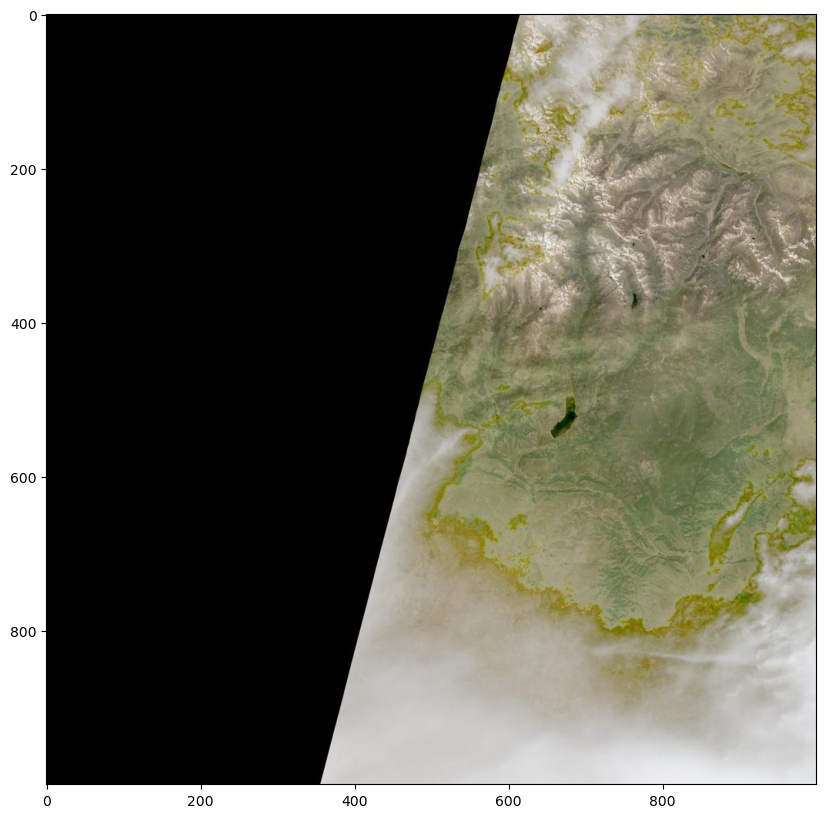

In [51]:
browse_urls = [granule.dataviz_links()[0] for granule in results]  # 0 retrieves only the https links

image = io.imread(browse_urls[10])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

del image

In [55]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
bands = {}
for e in evi_band_links:
    print(e)
    band_type = e.rsplit('.', 2)[-2]
    if band_type in evi_bands:  # Check if the band is relevant
        if band_type == evi_bands[0]:  # NIR index
            nir = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
            nir.attrs['scale_factor'] = 0.0001
            bands['NIR'] = nir
        elif band_type == evi_bands[1]:  # Red index
            red = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
            red.attrs['scale_factor'] = 0.0001
            bands['RED'] = red
        elif band_type == evi_bands[2]:  # Blue index
            blue = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
            blue.attrs['scale_factor'] = 0.0001
            bands['BLUE'] = blue
        elif band_type == evi_bands[3]:  # Fmask index
            fmask = rxr.open_rasterio(e, chunks=chunk_size, masked=True).astype('uint16').squeeze('band', drop=True)
            bands['FMask'] = fmask
print("The COGs have been loaded into memory!")

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T12SYG.2018137T174926.v2.0/HLS.L30.T12SYG.2018137T174926.v2.0.B05.tif
The COGs have been loaded into memory!


In [54]:
fmask

<xarray.DataArray (y: 3660, x: 3660)> Size: 27MB
dask.array<getitem, shape=(3660, 3660), dtype=uint16, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 29kB 4.2e+06 4.2e+06 4.2e+06 ... 4.09e+06 4.09e+06
    spatial_ref  int64 8B 0
Attributes: (12/35)
    ACCODE:                    Lasrc
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0
    arop_ave_yshift(meters):   0
    arop_ncp:                  0
    arop_rmse(meters):         0
    ...                        ...
    TIRS_SSM_POSITION_STATUS:  ESTIMATED
    ULX:                       699960
    ULY:                       4200000
    USGS_SOFTWARE:             LPGS_15.3.1c
    scale_factor:              1.0
    add_offset:                0.0

In [56]:
# create a data stack
stack_da = xr.Dataset(bands).rio.write_crs(nir.rio.crs)

In [57]:
stack_da

<xarray.Dataset> Size: 188MB
Dimensions:      (x: 3660, y: 3660)
Coordinates:
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 29kB 4.2e+06 4.2e+06 4.2e+06 ... 4.09e+06 4.09e+06
    spatial_ref  int64 8B 0
Data variables:
    BLUE         (y, x) float32 54MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    FMask        (y, x) uint16 27MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    RED          (y, x) float32 54MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    NIR          (y, x) float32 54MB dask.array<chunksize=(512, 512), meta=np.ndarray>

In [59]:
# crop to the fire bounds
if fire.crs != nir.rio.crs:
    print("Reprojecting the fire perimeter")
    fire = fire.to_crs(nir.rio.crs)

stack_da_fire = stack_da.rio.clip(fire.geometry.values, nir.rio.crs, all_touched=True)
stack_da_fire

<xarray.Dataset> Size: 7MB
Dimensions:      (x: 602, y: 807)
Coordinates:
  * x            (x) float64 5kB 7.648e+05 7.648e+05 ... 7.828e+05 7.828e+05
  * y            (y) float64 6kB 4.166e+06 4.166e+06 ... 4.142e+06 4.142e+06
    spatial_ref  int64 8B 0
Data variables:
    BLUE         (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    FMask        (y, x) uint16 972kB dask.array<chunksize=(410, 399), meta=np.ndarray>
    RED          (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    NIR          (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>

In [63]:
# mask occluded pixels using the FMask

def get_cloudmask(fmask_data, bit_nums: list = [1, 2, 3, 4, 5]):
    """
    Creates a binary mask of good pixels using the FMask layer and specified bit numbers.

    Parameters:
    - fmask_data: xarray.DataArray of the FMask layer.
    - bit_nums: List of bit positions to use for masking.

    Returns:
    - xarray.DataArray: Binary mask where True indicates masked (bad) pixels.
    """
    # Initialize the mask array with the same shape as FMask data
    mask = xr.zeros_like(fmask_data, dtype=bool)
    
    # Convert FMask data to integer, replacing NaN values with 0
    fmask_data = fmask_data.fillna(0).astype(np.int32)
    
    for bit in bit_nums:
        # Apply bitwise AND and shift to isolate the specified bit
        bit_mask = (fmask_data & (1 << bit)) > 0
        mask = mask | bit_mask  # Combine masks using logical OR

    return mask

# create the cloudmask layer
cloud_mask = get_cloudmask(stack_da_fire['FMask'], bit_nums=[1, 2, 3, 4, 5])
stack_da_fire_qc = stack_da_fire.where(~cloud_mask)
stack_da_fire_qc

<xarray.Dataset> Size: 8MB
Dimensions:      (y: 807, x: 602)
Coordinates:
  * x            (x) float64 5kB 7.648e+05 7.648e+05 ... 7.828e+05 7.828e+05
  * y            (y) float64 6kB 4.166e+06 4.166e+06 ... 4.142e+06 4.142e+06
    spatial_ref  int64 8B 0
Data variables:
    BLUE         (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    FMask        (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    RED          (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    NIR          (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>

In [64]:
# calculate EVI
def calc_evi(data_stack):
    """
    Calculate the Enhanced Vegetation Index (EVI) from an xarray.Dataset.

    Parameters:
    - data_stack: xarray.Dataset containing 'RED', 'BLUE', and 'NIR' DataArrays.

    Returns:
    - evi: xarray.DataArray containing the calculated EVI values.
    """
    # Extract bands
    red = data_stack['RED']
    blue = data_stack['BLUE']
    nir = data_stack['NIR']
    
    # Compute EVI
    evi_data = 2.5 * ((nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0))
    
    # Mask infinite values
    evi_data = xr.where(np.isfinite(evi_data), evi_data, np.nan)
    
    # Create EVI DataArray with metadata from the red band
    evi = red.copy(deep=True)
    evi.data = evi_data.data
    evi.attrs['long_name'] = 'Enhanced Vegetation Index'
    evi.attrs['scale_factor'] = 1.0
    evi.name = 'EVI'
    
    return evi

# apply to the data stack
evi = calc_evi(stack_da_fire_qc)
stack_da_fire_qc['EVI'] = evi
del evi

stack_da_fire_qc

<xarray.Dataset> Size: 10MB
Dimensions:      (y: 807, x: 602)
Coordinates:
  * x            (x) float64 5kB 7.648e+05 7.648e+05 ... 7.828e+05 7.828e+05
  * y            (y) float64 6kB 4.166e+06 4.166e+06 ... 4.142e+06 4.142e+06
    spatial_ref  int64 8B 0
Data variables:
    BLUE         (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    FMask        (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    RED          (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    NIR          (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>
    EVI          (y, x) float32 2MB dask.array<chunksize=(410, 399), meta=np.ndarray>

In [6]:
fileset = ea.open(results)

Opening 12 granules, approx size: 2.0 GB


QUEUEING TASKS | :   0%|          | 0/210 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/210 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/210 [00:00<?, ?it/s]

In [39]:
da = rxr.open_rasterio(fileset[0])
da

<xarray.DataArray (band: 1, y: 3660, x: 3660)> Size: 27MB
[13395600 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 2e+05 2e+05 2.001e+05 ... 3.097e+05 3.098e+05
  * y            (y) float64 29kB 4.2e+06 4.2e+06 4.2e+06 ... 4.09e+06 4.09e+06
    spatial_ref  int64 8B 0
Attributes: (12/42)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    AREA_OR_POINT:                                     Area
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    ...                                                ...
    spatial_coverage:                                  60
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_MT...
    ULX:                                               199980
    ULY:                                               4200000
    _FillValue:                                        -9999

In [54]:
fileset[0].url

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13SBB.2018140T175911.v2.0/HLS.S30.T13SBB.2018140T175911.v2.0.B03.tif'

In [8]:
bandnames = ['B8A', 'B04', 'B02', 'Fmask'] # bands to keep for index calculation
evi_fileset = [fp for fp in fileset if any(band in fp.url for band in bandnames)] # new fileset
print(f"Total of {len(evi_fileset)} bands.")

Total of 46 bands.


In [9]:
evi_fileset[0]

<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13SBB.2018140T175911.v2.0/HLS.S30.T13SBB.2018140T175911.v2.0.B04.tif>

In [ ]:
# set up the EVI calculate

In [ ]:
def stack_bands(bands):
    return stack

In [50]:
# get a list of bands we care about

# flatten the list of lists
granules = [url for sublist in hls_results_urls for url in sublist]
evi_band_links = [url for url in granules if any(band in url for band in bands)]

print(evi_band_links[0])

b04 = rxr.open_rasterio(evi_band_links[0])
b04

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13SBB.2018140T175911.v2.0/HLS.S30.T13SBB.2018140T175911.v2.0.B04.tif


In [40]:
da.shape

(1, 3660, 3660)